# 00. 개발 환경 설정

## 00-0. 필요 라이브러리 설치

In [1]:
!pip3 install pandas matplotlib scikit-learn

## 00-1. 라이브러리 import

In [2]:
# PyTorch의 필수 모듈 import
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset

# 데이터 분석, 수치 연산 및 시각화를 위한 라이브러리 import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 데이터 분할 및 레이블 인코딩을 위한 sklearn 도구 import
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# 텍스트 처리를 위한 정규 표현식과 단어 빈도 계산을 위한 Counter import
import re
from collections import Counter
import random

# nltk 라이브러리에서 PorterStemmer를 사용하여 단어를 어근으로 변환
from nltk.stem import PorterStemmer

## 00-3. 학습 디바이스 정의

In [3]:
# GPU 사용이 가능하면 'cuda', 그렇지 않으면 'cpu' 장치를 선택
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 현재 사용 중인 장치를 출력
print(f"Now using {device}.")

Now using cuda.


# 01. 학습 준비

## 01-1. 데이터셋 로드

In [4]:
# Google Colab에서 Google Drive를 사용하기 위한 모듈 import
#from google.colab import drive

# Google Drive를 '/content/drive' 경로에 마운트
#drive.mount('/content/drive')

In [5]:
# 파일 경로를 본인의 환경에 맞게 설정 (Google Drive 경로 또는 로컬 경로)
#file_path = '/content/drive/MyDrive/AI_security/HW2 - RNN 성능 향상/IMDB.csv'
# 로컬 환경에서 사용할 경우 주석 처리된 경로 사용 가능
file_path = './IMDB.csv'

# 지정된 파일 경로에서 CSV 파일을 읽어 데이터프레임으로 저장
df = pd.read_csv(file_path)

# 데이터프레임의 상위 5개 행 출력
print(df.head())

                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive


## 01-02. 데이터셋 전처리

In [6]:
# 텍스트를 정리하는 함수 정의
def text_cleaning(text):
    text = re.sub(r'<[^>]+>', '', text)  # HTML 태그 제거
    text = re.sub(r'[^a-zA-Z]', ' ', text)  # 알파벳이 아닌 문자 제거
    text = text.lower()  # 소문자로 변환
    text = text.split()  # 단어 단위로 분리
    return ' '.join(text)  # 단어를 다시 하나의 문자열로 결합

# 노이즈를 추가하는 함수 정의
def add_noise(text):
    noise_prob = 0.1  # 10% 확률로 노이즈 추가
    # 텍스트에서 무작위로 문자 또는 공백을 추가하여 노이즈 생성
    noisy_text = ''.join([char if random.random() > noise_prob else random.choice('abcdefghijklmnopqrstuvwxyz ') for char in text])
    return noisy_text

# 텍스트를 정규화하는 함수 정의
def normalize_text(text):
    text = text.lower()  # 소문자로 변환
    text = re.sub(r'[^\w\s]', '', text)  # 구두점 제거
    text = re.sub(r'\s+', ' ', text)  # 여러 공백을 하나로 변환
    return text

# 데이터프레임의 'review' 열에 대해 텍스트 정리 함수 적용
df['review'] = df['review'].apply(text_cleaning)

# 'review' 열에 노이즈 추가
noisy_reviews = df['review'].apply(add_noise)

# 'review' 열에 정규화 적용
normalized_reviews = df['review'].apply(normalize_text)

# 원래 리뷰와 노이즈가 추가된 리뷰를 모두 결합
all_reviews = df['review'].tolist() + noisy_reviews.tolist()

# 각 데이터셋에 대해 동일한 라벨 사용
all_labels = df['sentiment'].tolist() * 2

# 감정(라벨)을 인코딩 (긍정, 부정 라벨을 숫자로 변환)
label_encoder = LabelEncoder()
df['sentiment'] = label_encoder.fit_transform(df['sentiment'])

# 'review' 열을 다시 정규화
df['review'] = df['review'].apply(normalize_text)

# 텍스트와 라벨 준비 (리스트로 변환)
text = df['review'].tolist()
label = df['sentiment'].tolist()

# 데이터셋을 훈련 및 테스트 세트로 분할 (80% 훈련, 20% 테스트)
x_train, x_test, y_train, y_test = train_test_split(text, label, test_size=0.2, random_state=42, shuffle=True)

# 어휘를 구축하는 함수 정의 (min_freq 이상 등장하는 단어만 포함)
def build_vocab(data, min_freq=5):
    counter = Counter()  # 단어의 빈도를 계산하기 위한 Counter 객체 생성

    # 각 리뷰에서 단어를 분리하고 빈도 계산
    for review in data:
        words = review.split()
        counter.update(words)

    # 어휘 사전 생성, 처음에는 <unk> 토큰을 0번 인덱스로 추가
    vocab = {'<unk>': 0}
    index = 1

    # 빈도가 min_freq 이상인 단어들을 어휘 사전에 추가
    for word, count in counter.items():
        if count >= min_freq:
            vocab[word] = index
            index += 1

    return vocab

# 훈련 데이터로부터 어휘 사전 구축
vocab = build_vocab(x_train)

# 어휘 크기 출력
print(f"Vocabulary Size: {len(vocab)}")

Vocabulary Size: 35706


In [7]:
# 평균 문장 길이를 계산하는 함수
def get_avg_length(text_list):
    if not text_list:
        return 0
    # 각 문장의 단어 수를 계산하여 평균을 구함
    avg_length = sum(len(sentence.split()) for sentence in text_list) / len(text_list)
    return int(avg_length)

# 시퀀스를 패딩하는 함수 (고정된 길이로 맞추기)
def pad_sequence(seq, max_length, pad_value=0):
    # 시퀀스 길이가 max_length보다 짧으면 패딩을 추가하고, 길면 자름
    return seq + [pad_value] * (max_length - len(seq)) if len(seq) < max_length else seq[:max_length]

# 단어를 무작위로 섞는 함수
def shuffle_words(text):
    words = text.split()  # 텍스트를 단어로 분리
    random.shuffle(words)  # 단어를 무작위로 섞음
    return ' '.join(words)  # 다시 단어를 결합하여 문자열 반환

# 불용어(stop words)를 제거하는 함수
stop_words = set(["the", "is", "in", "and", "to", "a"])  # 필요한 경우 불용어 리스트 확장 가능

def remove_stop_words(text):
    # 불용어가 아닌 단어만 남기고 다시 결합하여 반환
    return ' '.join(word for word in text.split() if word not in stop_words)

# Stemming 함수 (PorterStemmer 사용 예시)
stemmer = PorterStemmer()

def stem_text(text):
    # 각 단어에 대해 어근 추출을 수행하고 다시 결합하여 반환
    return ' '.join(stemmer.stem(word) for word in text.split())

# 텍스트를 인코딩하고 패딩하는 함수
def text_encoding(text_list, vocab, max_length):
    # 각 문장을 인코딩하고, 지정된 max_length로 패딩
    encoded_padded_sequences = [
        pad_sequence(
            [vocab.get(word, vocab['<unk>']) for word in remove_stop_words(normalize_text(sentence)).split()],  # 단어를 어휘 사전에서 인코딩
            max_length  # max_length로 패딩
        )
        for sentence in text_list
    ]
    return encoded_padded_sequences

# 샘플 사용 예시
max_length = 300  # 고정된 최대 길이 설정
x_train = text_encoding(x_train, vocab, max_length)  # 훈련 데이터를 인코딩 및 패딩
x_test = text_encoding(x_test, vocab, max_length)  # 테스트 데이터를 인코딩 및 패딩

In [8]:
# IMDB 데이터셋을 위한 커스텀 Dataset 클래스 정의
class IMDBDataset(Dataset):
    def __init__(self, text_encoded, label):
        # 인코딩된 텍스트 데이터와 라벨을 클래스 변수로 저장
        self.text_encoded = text_encoded
        self.label = label

    # 데이터셋의 전체 길이를 반환하는 메서드
    def __len__(self):
        return len(self.label)

    # 주어진 인덱스에 해당하는 데이터(리뷰와 라벨)를 반환하는 메서드
    def __getitem__(self, idx):
        review = self.text_encoded[idx]  # 인코딩된 리뷰 텍스트
        label = self.label[idx]  # 감정 라벨 (긍정/부정)
        return review, label

# 훈련 데이터셋 생성 (리뷰와 라벨을 텐서로 변환하여 Dataset으로 만듦)
train_dataset = IMDBDataset(torch.tensor(x_train), torch.tensor(y_train))

# 훈련 데이터를 배치로 묶어주기 위해 DataLoader 사용, 배치 크기는 32, 데이터를 무작위로 섞음
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# 테스트 데이터셋 생성
test_dataset = IMDBDataset(torch.tensor(x_test), torch.tensor(y_test))

# 테스트 데이터를 배치로 묶기 위해 DataLoader 사용
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

# 02. 모델 준비

## 02-01. RNN

In [9]:
import torch.nn as nn
import torch

# RNN 모델 클래스 정의
class RNNModel(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim, num_layers=1, padding_idx=0):
        super(RNNModel, self).__init__()

        # 임베딩 레이어: 입력 차원(input_dim) 크기의 단어를 임베딩 차원(embedding_dim) 크기로 변환
        # padding_idx는 패딩을 무시하는 역할
        self.embedding = nn.Embedding(input_dim, embedding_dim, padding_idx=padding_idx)

        # GRU 레이어: 임베딩된 입력을 GRU를 통해 처리
        # embedding_dim: 입력 차원, hidden_dim: 은닉 상태 크기, num_layers: GRU 층 수
        self.rnn = nn.GRU(embedding_dim, hidden_dim, num_layers=num_layers, batch_first=True)

        # 출력 레이어: GRU의 마지막 은닉 상태를 출력 크기(output_dim)로 변환
        self.fc = nn.Linear(hidden_dim, output_dim)

        # 드롭아웃 레이어: 30% 드롭아웃 비율 적용
        self.dropout = nn.Dropout(0.3)

        # 모델 내부에서 사용할 num_layers와 padding_idx 저장
        self.num_layers = num_layers
        self.padding_idx = padding_idx

    def forward(self, text):
        # 입력 텍스트에서 패딩이 아닌 부분의 길이를 계산하고 CPU로 이동
        lengths = (text != self.padding_idx).sum(dim=1).cpu()

        # 텍스트를 임베딩하여 벡터로 변환
        embedded = self.embedding(text)

        # 패딩이 있는 시퀀스를 패킹하여 GRU에 전달 (정렬 강제 비활성화)
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, lengths, batch_first=True, enforce_sorted=False)

        # GRU를 통해 패킹된 입력을 처리, 은닉 상태(hidden) 반환
        packed_output, hidden = self.rnn(packed_embedded)

        # GRU의 마지막 레이어의 마지막 은닉 상태 가져오기
        last_hidden = hidden[-1]

        # 드롭아웃을 적용하고 fully connected layer에 전달
        last_hidden = self.dropout(last_hidden)
        output = self.fc(last_hidden)

        # 최종 출력 반환
        return output

In [10]:
# 어휘 사전의 크기 설정
vocab_size = len(vocab)

# 임베딩 차원 설정 (각 단어를 300차원 벡터로 변환)
embed_size = 300

# 은닉 상태의 크기 설정
hidden_size = 512

# 출력 크기 설정 (이진 분류이므로 1로 설정)
output_size = 1

# RNN 모델 인스턴스 생성
# num_layers=2로 설정하여 두 개의 GRU 레이어 사용
model = RNNModel(vocab_size, embed_size, hidden_size, output_size, num_layers=2).to(device)

# 모델 구조 출력
model

RNNModel(
  (embedding): Embedding(35706, 300, padding_idx=0)
  (rnn): GRU(300, 512, num_layers=2, batch_first=True)
  (fc): Linear(in_features=512, out_features=1, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)

# 03. 모델 학습

In [11]:
# 훈련할 에폭 수 설정
epochs = 5

# 손실 함수 설정: 이진 분류에 적합한 BCEWithLogitsLoss 사용
loss_fn = nn.BCEWithLogitsLoss()

# 옵티마이저 설정: Adam 옵티마이저, 학습률 0.001, L2 정규화 사용
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

# 학습률 스케줄러 설정: validation loss가 개선되지 않을 경우 학습률 감소
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=3, min_lr=1e-6)

# 모델 훈련 함수 정의
def train(model, data_loader, optimizer, loss_fn):
    model.train()  # 모델을 훈련 모드로 설정
    total_loss = 0  # 총 손실 초기화
    correct = 0  # 정확도 카운터 초기화

    # 데이터 로더에서 배치별로 반복
    for batch in data_loader:
        text, label = batch  # 배치에서 텍스트와 라벨 추출
        text = text.to(device)  # 텍스트를 지정된 디바이스로 이동
        label = label.to(device)  # 라벨을 지정된 디바이스로 이동
        label = label.unsqueeze(1).float()  # 라벨의 차원 추가 (배치 크기, 1로 변환)

        optimizer.zero_grad()  # 그래디언트 초기화
        output = model(text)  # 모델에 텍스트 입력하여 출력 계산
        loss = loss_fn(output, label)  # 손실 계산
        loss.backward()  # 그래디언트 계산
        optimizer.step()  # 옵티마이저 업데이트

        total_loss += loss.item()  # 총 손실 업데이트

        # 예측값 계산
        predictions = torch.round(torch.sigmoid(output))  # 시그모이드 함수를 통해 예측값 얻기
        correct += (predictions == label).float().sum()  # 정확도 계산

    average_loss = total_loss / len(data_loader)  # 평균 손실 계산
    accuracy = correct / len(data_loader.dataset)  # 정확도 계산

    return average_loss, accuracy  # 평균 손실과 정확도 반환

# 모델 평가 함수 정의
def evaluate(model, data_loader, loss_fn):
    model.eval()  # 모델을 평가 모드로 설정
    total_loss = 0  # 총 손실 초기화
    correct = 0  # 정확도 카운터 초기화

    with torch.no_grad():  # 그래디언트 계산 비활성화
        for batch in data_loader:
            text, label = batch  # 배치에서 텍스트와 라벨 추출
            text = text.to(device)  # 텍스트를 지정된 디바이스로 이동
            label = label.to(device)  # 라벨을 지정된 디바이스로 이동
            label = label.unsqueeze(1).float()  # 라벨의 차원 추가 (배치 크기, 1로 변환)

            output = model(text)  # 모델에 텍스트 입력하여 출력 계산
            loss = loss_fn(output, label)  # 손실 계산
            total_loss += loss.item()  # 총 손실 업데이트

            predictions = torch.round(torch.sigmoid(output))  # 예측값 계산
            correct += (predictions == label).float().sum()  # 정확도 계산

    average_loss = total_loss / len(data_loader)  # 평균 손실 계산
    accuracy = correct / len(data_loader.dataset)  # 정확도 계산

    return average_loss, accuracy  # 평균 손실과 정확도 반환

# 훈련 루프 초기화
train_losses = []  # 훈련 손실 저장 리스트
val_losses = []  # 검증 손실 저장 리스트
val_accuracies = []  # 검증 정확도 저장 리스트

# 에폭별로 훈련 및 평가 반복
for epoch in range(epochs):
    train_loss, train_acc = train(model, train_loader, optimizer, loss_fn)  # 모델 훈련
    val_loss, val_acc = evaluate(model, test_loader, loss_fn)  # 모델 평가

    # 학습률 스케줄러 업데이트
    scheduler.step(val_loss)

    # 에폭, 훈련 손실, 검증 손실, 검증 정확도 출력
    print(f'Epoch {epoch+1}, Train Loss: {train_loss:.3f}, Validation Loss: {val_loss:.3f}, Validation Accuracy: {val_acc.item()*100:.2f}%')

    # 손실 및 정확도 저장
    train_losses.append(train_loss)  # 훈련 손실을 리스트에 추가
    val_losses.append(val_loss)  # 검증 손실을 리스트에 추가
    val_accuracies.append(val_acc.detach().cpu())  # CPU로 이동하여 저장

Epoch 1, Train Loss: 0.517, Validation Loss: 0.328, Validation Accuracy: 86.24%
Epoch 2, Train Loss: 0.284, Validation Loss: 0.274, Validation Accuracy: 88.51%
Epoch 3, Train Loss: 0.240, Validation Loss: 0.248, Validation Accuracy: 89.59%
Epoch 4, Train Loss: 0.210, Validation Loss: 0.240, Validation Accuracy: 90.51%
Epoch 5, Train Loss: 0.187, Validation Loss: 0.239, Validation Accuracy: 90.72%


# 05. 결과 시각화

## 05-01. 학습 결과

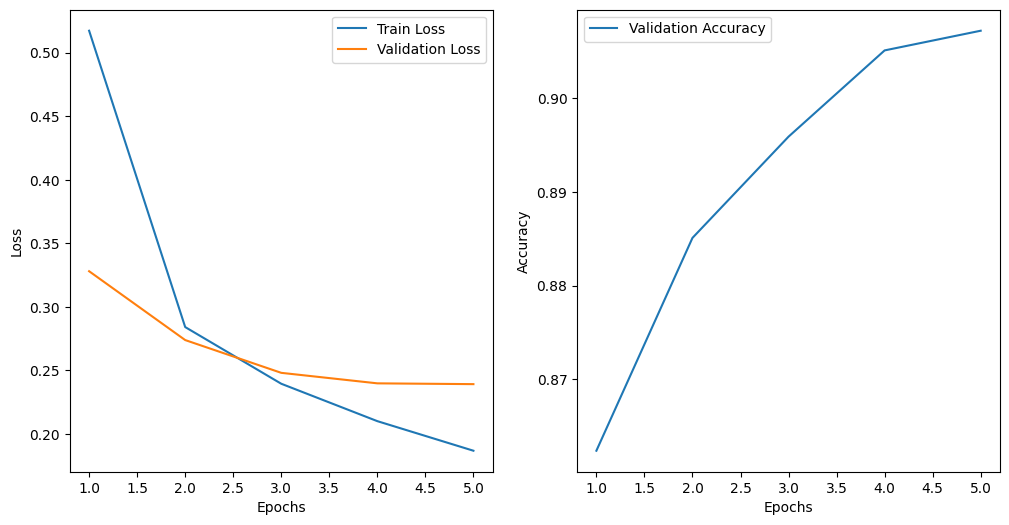

In [12]:
# 손실 및 정확도 시각화를 위한 그래프 설정
plt.figure(figsize=(12, 6))  # 전체 그림 크기 설정

# 손실 그래프
plt.subplot(1, 2, 1)  # 1행 2열의 첫 번째 서브플롯
plt.plot(range(1, epochs + 1), train_losses, label='Train Loss')  # 훈련 손실 그래프
plt.plot(range(1, epochs + 1), val_losses, label='Validation Loss')  # 검증 손실 그래프
plt.xlabel('Epochs')  # x축 레이블 설정
plt.ylabel('Loss')  # y축 레이블 설정
plt.legend()  # 범례 표시

# 정확도 그래프
plt.subplot(1, 2, 2)  # 1행 2열의 두 번째 서브플롯
plt.plot(range(1, epochs + 1), val_accuracies, label='Validation Accuracy')  # 검증 정확도 그래프
plt.xlabel('Epochs')  # x축 레이블 설정
plt.ylabel('Accuracy')  # y축 레이블 설정
plt.legend()  # 범례 표시

# 그래프 출력
plt.show()  # 시각화된 그래프 표시